In [1]:
# -*- coding: utf-8 -*-  # 指定源代码文件的编码为UTF-8，确保中文字符正常显示

import collections  # 导入collections模块，用于计数和其他容器数据结构操作
import torch  # 导入PyTorch库，用于构建和训练深度学习模型
import torch.nn as nn  # 从torch中导入神经网络模块，便于构建各类神经网络层
import numpy as np  # 导入NumPy库，用于高效的数组运算和数值计算
from sklearn.neighbors import NearestNeighbors  # 从scikit-learn中导入最近邻算法，用于生成SMOTE样本
import os  # 导入os模块，用于文件和目录操作

print(torch.version.cuda)  # 打印当前PyTorch使用的CUDA版本，如输出"10.1"

import time  # 导入time模块，用于记录和计算时间
t0 = time.time()  # 记录程序开始时的时间，用于后续计算整个程序的运行时长


None


In [2]:
print(torch.version.cuda)  # 打印当前PyTorch使用的CUDA版本，例如显示"10.1"

t3 = time.time()  # 记录程序开始时的时间，用于后续计算总运行时间
##############################################################################
"""args for AE"""
# 以下部分设置自动编码器（AE）的相关参数
args = {}  # 创建一个空字典，用于存放模型和训练的参数
args['dim_h'] = 64         # 设置隐藏层通道数的基础因子，后续卷积层的通道数会成倍增加
args['n_channel'] = 1  #3    # 输入数据的通道数，1表示灰度图（3则为彩色图）；这里选用灰度图
args['n_z'] = 300 #600     # 潜在空间（编码空间）的维度数，决定编码器输出特征向量的大小
args['sigma'] = 1.0        # 潜在空间中使用的方差参数，可用于正则化
args['lambda'] = 0.01      # 判别器损失的权重超参数（如在对抗训练中使用）
args['lr'] = 0.0002        # Adam优化器的学习率，决定参数更新的步长
args['epochs'] = 50       # 训练过程中遍历数据集的轮数
args['batch_size'] = 64   # 每个训练批次的样本数量
args['save'] = True        # 如果为True，则在每个训练轮结束时保存模型权重
args['train'] = True       # 若为True则进行训练，否则加载已保存的模型进行测试
args['dataset'] = 'mnist34'  #'fmnist' # 指定使用的数据集，这里选择MNIST数据集 mnist34 mnist17 fashionmnist34 cifar10
args['fraction'] = 0.005   # 用于训练的数据集的子集比例，可用于快速测试

##############################################################################
print(args)

None
{'dim_h': 64, 'n_channel': 1, 'n_z': 300, 'sigma': 1.0, 'lambda': 0.01, 'lr': 0.0002, 'epochs': 50, 'batch_size': 64, 'save': True, 'train': True, 'dataset': 'mnist34', 'fraction': 0.005}


In [3]:
## create encoder model and decoder model
# 定义编码器（Encoder）模型和解码器（Decoder）模型

class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()  # 调用父类(nn.Module)的构造函数
        self.n_channel = args['n_channel']  # 获取输入数据的通道数
        self.dim_h = args['dim_h']          # 获取隐藏层基准通道数
        self.n_z = args['n_z']              # 获取潜在空间的维度

        # 定义一系列卷积层，用于提取图像特征
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),  
            # 第一层卷积：输入通道数为n_channel，输出通道数为dim_h，卷积核大小4，步幅2，填充1，不使用偏置
            # nn.ReLU(True),  # 可选ReLU激活（已注释）
            nn.LeakyReLU(0.2, inplace=True),  # 使用LeakyReLU激活函数，负半部分斜率0.2
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),  
            # 第二层卷积：通道数从dim_h增加到dim_h*2
            nn.BatchNorm2d(self.dim_h * 2),  # 对第二层卷积输出进行批归一化
            # nn.ReLU(True),  # 可选ReLU激活（已注释）
            nn.LeakyReLU(0.2, inplace=True),  # 激活函数
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),  
            # 第三层卷积：通道数从dim_h*2增加到dim_h*4
            nn.BatchNorm2d(self.dim_h * 4),  # 批归一化
            # nn.ReLU(True),  # 可选激活（已注释）
            nn.LeakyReLU(0.2, inplace=True),  # 激活函数

            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),  
            # 第四层卷积：通道数从dim_h*4增加到dim_h*8
            # 下面是备用配置（注释掉的3d和32x32的卷积配置）
            # nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),  # 对第四层卷积输出进行批归一化，注释中提到“40 X 8 = 320”
            # nn.ReLU(True),  # 可选激活（已注释）
            nn.LeakyReLU(0.2, inplace=True)   # 使用LeakyReLU激活函数
            # 注释掉的备用层：可能用于调整输出尺寸，如使用nn.Conv2d(self.dim_h * 8, 1, 2, 1, 0, bias=False)
        )
        # 最后一层为全连接层，将卷积层输出映射到潜在空间
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)
        # 注意：这里dim_h * (2 ** 3)等价于dim_h * 8，假定卷积层输出的特征维度为该值

    def forward(self, x):
        # 前向传播函数
        # print('enc')  # 调试用，打印“enc”
        # print('input ', x.size())  # 可打印输入张量的尺寸（例如[batch, channel, H, W]）
        x = self.conv(x)  # 将输入x通过卷积层提取特征
        # print('aft conv ', x.size())  # 调试用，打印经过卷积层后的尺寸
        x = x.squeeze()  # 压缩张量，移除尺寸为1的维度（例如将[batch, 320, 1, 1]压缩为[batch, 320]）
        # print('aft squeeze ', x.size())  # 调试用，打印压缩后的尺寸
        x = self.fc(x)  # 将压缩后的特征通过全连接层映射到潜在空间维度
        # print('out ', x.size())  # 调试用，打印最终输出尺寸，应为[batch, n_z]
        return x  # 返回编码后的潜在向量

# 定义解码器模型，用于将潜在向量还原成图像
class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()  # 调用父类构造函数
        self.n_channel = args['n_channel']  # 获取输出图像的通道数
        self.dim_h = args['dim_h']          # 获取隐藏层基准通道数
        self.n_z = args['n_z']              # 获取潜在向量的维度

        # 定义全连接层，将潜在向量扩展为足够还原为卷积特征图的尺寸
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),  # 将潜在向量映射到大小为dim_h*8*7*7的特征向量
            nn.ReLU()  # 使用ReLU激活函数
        )

        # 定义反卷积层（转置卷积），用于将全连接层的输出还原为图像
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),  
            # 第一层反卷积：将通道数从dim_h*8降到dim_h*4，卷积核大小为4
            nn.BatchNorm2d(self.dim_h * 4),  # 批归一化
            nn.ReLU(True),  # 激活函数
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),  
            # 第二层反卷积：通道数从dim_h*4降到dim_h*2
            nn.BatchNorm2d(self.dim_h * 2),  # 批归一化
            nn.ReLU(True),  # 激活函数
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),  
            # 第三层反卷积：将通道数降为1，同时上采样，恢复图像尺寸
            # nn.Sigmoid()  # 可选Sigmoid激活，使输出在[0,1]之间（已注释）
            nn.Tanh()  # 使用Tanh激活函数，将输出映射到[-1, 1]
        )

    def forward(self, x):
        # 前向传播函数
        # print('dec')  # 调试用，打印“dec”
        # print('input ', x.size())  # 可打印输入潜在向量尺寸
        x = self.fc(x)  # 通过全连接层扩展潜在向量
        x = x.view(-1, self.dim_h * 8, 7, 7)  
        # 将全连接层输出重塑为形状为[batch, dim_h*8, 7, 7]的特征图，为反卷积做准备
        x = self.deconv(x)  # 将特征图通过反卷积层还原成图像
        return x  # 返回重构后的图像

In [4]:
##############################################################################
# 定义辅助函数，用于生成SMOTE图像和获取特定类别数据

def biased_get_class1(c):
    # 根据给定类别c，从全局变量dec_x和dec_y中筛选出该类别的样本
    xbeg = dec_x[dec_y == c]  # 选择图像中标签等于c的部分
    ybeg = dec_y[dec_y == c]  # 选择标签中等于c的部分
    return xbeg, ybeg  # 返回该类别的图像和标签
    # return xclass, yclass  # 备用返回方式（已注释）

def G_SM1(X, y, n_to_sample, cl):
    # 根据SMOTE思想生成合成样本
    # fitting the model
    n_neigh = 5 + 1  # 设置最近邻数量为6（包含样本自身）
    nn = NearestNeighbors(n_neighbors=n_neigh, n_jobs=1)  # 初始化最近邻对象，使用单线程
    nn.fit(X)  # 用数据X拟合最近邻模型
    dist, ind = nn.kneighbors(X)  # 获取每个样本的邻居索引和距离

    # generating samples
    base_indices = np.random.choice(list(range(len(X))), n_to_sample)
    # 从所有样本中随机选择n_to_sample个作为基样本
    neighbor_indices = np.random.choice(list(range(1, n_neigh)), n_to_sample)
    # 对每个基样本随机选择一个邻居（排除自身索引0）

    X_base = X[base_indices]  # 获取基样本数据
    X_neighbor = X[ind[base_indices, neighbor_indices]]  # 获取对应邻居数据

    samples = X_base + np.multiply(np.random.rand(n_to_sample, 1),
                                   X_neighbor - X_base)
    # 在基样本与邻居之间做随机线性插值，生成新的合成样本

    # use 10 as label because 0 to 9 real classes and 1 fake/smoted = 10
    return samples, [cl] * n_to_sample
    # 返回生成的样本及其标签列表（所有生成样本标签均为cl）

This is the MNIST dataset with labels 3 and 4.
Imbalanced Ratio:  0.005
Number of label 3 in the final training set:  6131
Number of label 4 in the final training set (after downsampling):  30
Number of label 3 in the final test set:  1010
Number of label 4 in the final test set:  982
Total samples in final training set:  6161
Total samples in final test set:  1992
Number of batches in training set:  97
Number of batches in test set:  32
Images shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])
First image tensor:
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.

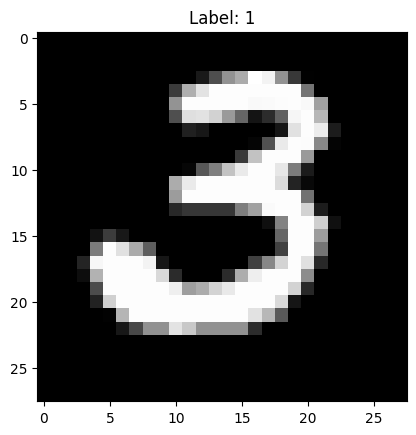

X_train.shape: (6161, 784)
y_train.shape: (6161,)
X_test.shape: (1992, 784)
y_test.shape: (1992,)


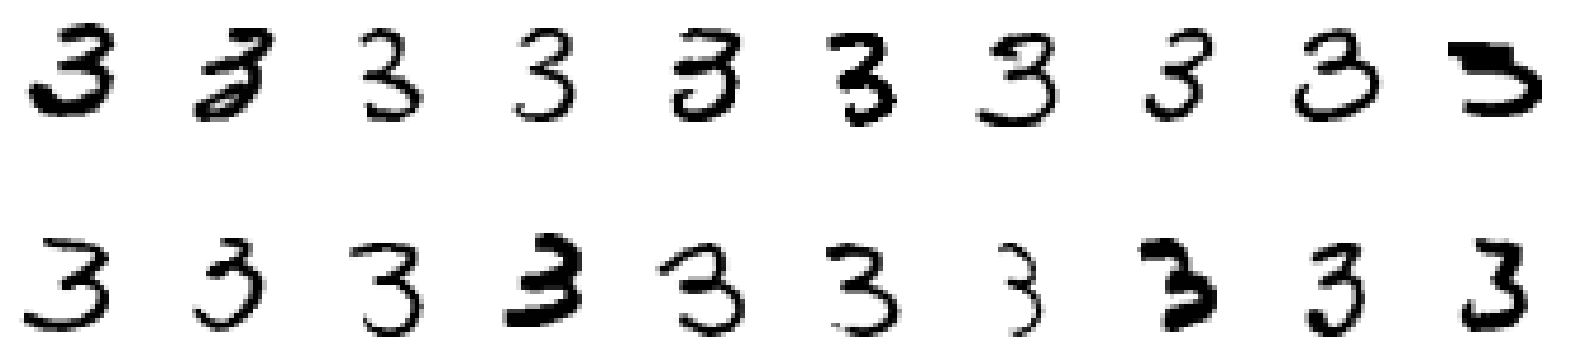

In [5]:
np.printoptions(precision=5, suppress=True) # 设置NumPy打印精度，避免科学计数法
from Get_datasets import get_datasets
X_train,y_train ,X_test,y_test = get_datasets(dataname='mnist34',fraction=args['fraction'])

In [6]:
dec_x = X_train
dec_y = y_train
print("training data shape: ", dec_x.shape, dec_y.shape)
print("testing data shape: ", X_test.shape, y_test.shape)
dec_x = dec_x.reshape(dec_x.shape[0], 1, 28, 28)
# 将图像数据重塑为[样本数, 通道数, 高, 宽]，这里假定图像大小为28x28，通道数为1

print('decy ', dec_y.shape)  # 再次打印标签形状
print(collections.Counter(dec_y))  # 统计并打印每个标签的样本数量分布

print('train imgs after reshape ', dec_x.shape)  
# 打印重塑后的图像数据形状，例如(45000, 1, 28, 28)
classes = ('0','1')
# 生成一些样本（平衡数据）：
train_on_gpu = torch.cuda.is_available()  # 检查是否有可用GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # 指定使用的设备
path_encoder = "/Users/max/MasterThesis/Training/Binary_DeepSMOTE/DeepSMOTE_0.005_bst_dec.pth"
path_decoder = "/Users/max/MasterThesis/Training/Binary_DeepSMOTE/DeepSMOTE_0.005_bst_enc.pth"
encoder = Encoder(args) # 创建编码器模型
encoder.load_state_dict(torch.load(path_encoder),strict=False)  # 加载预训练的编码器模型权重
encoder = encoder.to(device)  # 将编码器模型移动到指定设备

decoder = Decoder(args)  # 创建解码器模型
decoder.load_state_dict(torch.load(path_decoder),strict=False)  # 加载预训练的解码器模型权重
decoder = decoder.to(device)  # 将解码器模
encoder.eval()  # 设置编码器为评估模式
decoder.eval()  # 设置解码器为评估模式

num_samples1 = collections.Counter(dec_y).most_common()[0][1]  # 获取最多类别的样本数
num_samples0 = collections.Counter(dec_y).most_common()[-1][1]  # 获取最少类别的样本数
num_samples = num_samples1 - num_samples0  # 计算样本数差值
print('num_samples ', num_samples)
#imbalnced = [0,num_samples] # 定义一个列表，用于存放不平衡类别的样本索引
resx = []   # 用于存放生成的样本
resy = []   # 用于存放生成的样本标签

xclass, yclass = biased_get_class1(0)
print('xclass ', xclass.shape)
print(yclass[0])

xclass = torch.Tensor(xclass).to(device)  # 将数据转换为张量并移动到指定设备
xclass = encoder(xclass)  # 使用编码器将数据编码为潜在向量
print('xclass ', xclass.shape)

xclass = xclass.cpu().detach().numpy()  # 将编码后的数据移动到CPU并转换为NumPy数组
n = num_samples
xsamp, ysamp = G_SM1(xclass, yclass, n, 0)  # 生成合成样本
print('xsamp ', xsamp.shape)
print('ysamp ', len(ysamp))
ysamp = np.array(ysamp)  # 将标签列表转换为NumPy数组
print('ysamp ', ysamp.shape)

"""to generate samples for resnet"""
xsamp = torch.Tensor(xsamp)  
# 将生成的潜在向量样本转换为Tensor
xsamp = xsamp.to(device)  
# 将样本移到设备上
# xsamp = xsamp.view(xsamp.size()[0], xsamp.size()[1], 1, 1)
# 上面代码（已注释）用于将向量调整形状为[batch, n_z, 1, 1]，如果需要可启用
# print(xsamp.size())  # 调试用，打印转换后张量的形状
ximg = decoder(xsamp)  
# 通过解码器将潜在向量转换为图像

ximn = ximg.detach().cpu().numpy()  
# 将解码器输出的图像从Tensor转换为NumPy数组
print(ximn.shape)  # 打印生成图像的形状，例如(4500, 1, 28, 28)
# ximn = np.expand_dims(ximn, axis=1)  # 可选扩展维度（已注释）
print(ximn.shape)  # 再次打印图像数组形状，确认不变
resx.append(ximn)  # 将生成的图像添加到列表resx中
resy.append(ysamp)  # 将生成的标签添加到列表resy中

resx1 = np.vstack(resx)  # 将生成的图像堆叠为一个数组
resy1 = np.hstack(resy)  # 将生成的标签堆叠为一个数组
print('resx1 ', resx1.shape)
print('resy1 ', resy1.shape)

resx1 = resx1.reshape(resx1.shape[0], -1) 
print('resx1 ', resx1.shape) #

dec_x1 = dec_x.reshape(dec_x.shape[0], -1)
print('dec_x1 ', dec_x1.shape)
combx = np.vstack((dec_x1, resx1))
comby = np.hstack((dec_y, resy1))
print(combx.shape)  # 打印合并后图像数据的形状，例如(45000, 3072)
print(comby.shape)  # 打印合并后标签数据的形状，例如(45000,)
print(collections.Counter(comby))  # 统计并打印合并后数据集的标签分布

# 保存生成的数据集
new_datasets = torch.utils.data.TensorDataset(torch.Tensor(combx), torch.LongTensor(comby))
##############################################################################
save_data_path = '/Users/max/MasterThesisData/DeepSMOTE/{}_datasets_{}.pt'.format(args['dataset'], args['fraction'])
torch.save(new_datasets, save_data_path)
print(f"Dataset saved to {save_data_path}")


training data shape:  (6161, 784) (6161,)
testing data shape:  (1992, 784) (1992,)
decy  (6161,)
Counter({np.int64(1): 6131, np.int64(0): 30})
train imgs after reshape  (6161, 1, 28, 28)
num_samples  6101
xclass  (30, 1, 28, 28)
0
xclass  torch.Size([30, 300])
xsamp  (6101, 300)
ysamp  6101
ysamp  (6101,)
(6101, 1, 28, 28)
(6101, 1, 28, 28)
resx1  (6101, 1, 28, 28)
resy1  (6101,)
resx1  (6101, 784)
dec_x1  (6161, 784)
(12262, 784)
(12262,)
Counter({np.int64(1): 6131, np.int64(0): 6131})
Dataset saved to /Users/max/MasterThesisData/DeepSMOTE/mnist34_datasets_0.005.pt


In [8]:
import torch

from torch.utils.data import DataLoader
# Path to the saved dataset
file_path = "/Users/max/MasterThesisData/DeepSMOTE/mnist34_datasets_0.005.pt"

# Load the dataset
loaded_dataset = torch.load(file_path, weights_only=False)
# Create a DataLoader
batch_size = 64
data_loader = DataLoader(loaded_dataset, batch_size=batch_size, shuffle=True)

# Iterate through the DataLoader
for batch_idx, (data, target) in enumerate(data_loader):
    print(f"Batch {batch_idx}: Data shape {data.shape}, Target shape {target.shape}")
    break  # Print first batch only

t1 = time.time()  # 记录整个程序结束时的时间
print('final time(min): {:.2f}'.format((t1 - t0) / 60))  
# 计算并打印整个程序运行的时间（单位：分钟）

Batch 0: Data shape torch.Size([64, 784]), Target shape torch.Size([64])
final time(min): 0.50


Images shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])
First image tensor:
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.00

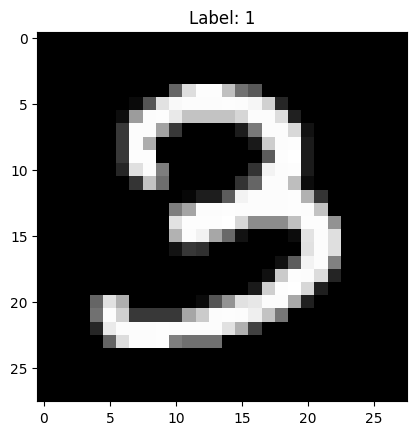

In [9]:
import matplotlib.pyplot as plt
# 获取一个 batch
images, labels = next(iter(data_loader))
images = images.reshape(-1,1, 28, 28)  # 重塑图像数据形状

# 查看 Tensor 形状
print(f"Images shape: {images.shape}")  # 形状为 (batch_size, channels, height, width)
print(f"Labels shape: {labels.shape}")  # 形状为 (batch_size,)

# 查看第一个样本的 Tensor 值
print(f"First image tensor:\n{images[0]}")  # 打印第一个样本的 Tensor 数据
print(f"First image label: {labels[0]}")  # 打印第一个样本的标签

plt.imshow(images[0].squeeze().numpy(), cmap="gray")
plt.title(f"Label: {labels[0].item()}")
plt.show()